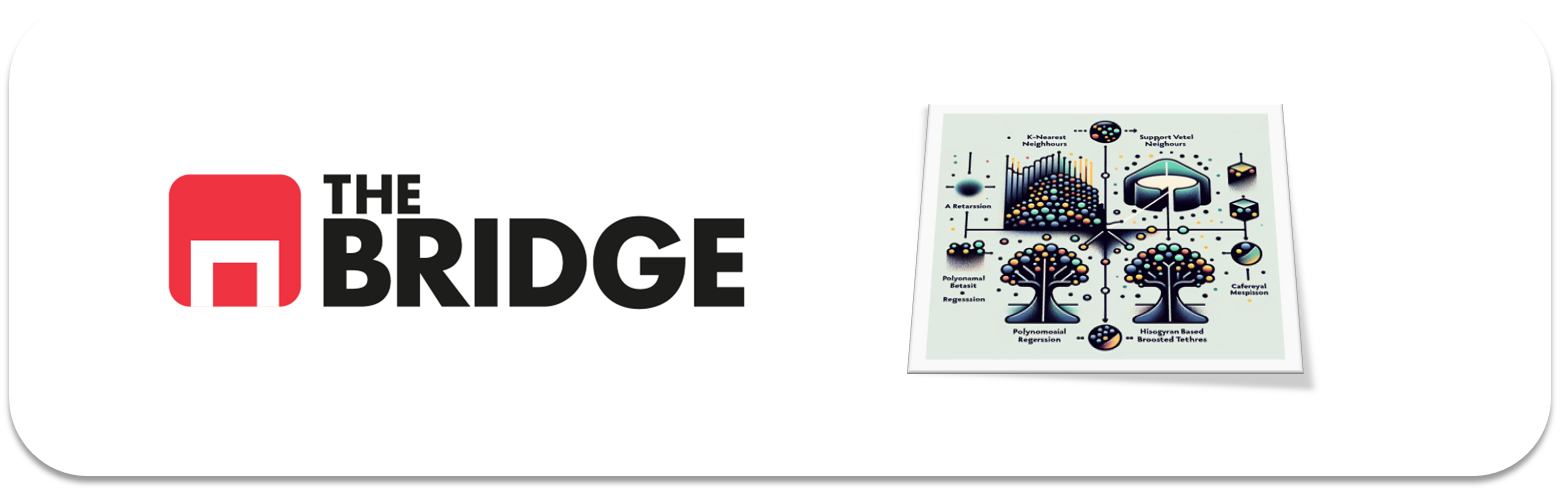

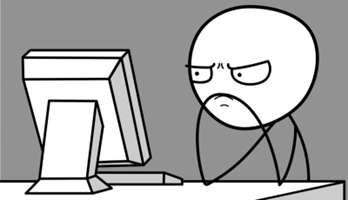

Para hacer un **repaso a los problemas de clasificacion con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Equilibrado del train set  
10. Evaluación contra test.  
11. Análisis de errores, posibles acciones futuras.  
12. EXTRA: Persistencia del modelo en disco.  

### El problema

La unidad oncológica del hospital de Madison, Wisconsin, está trabajando en un tratamiento muy prometedor sobre el cáncer de mama. Desgraciadamente es un tratamiento con efectos secundarios y todavía excesivamente caro, pero cuya efectividad es extraordinaria si se aplica en las primeras etpas o incluso antes de haberlo desarrollado. 

En este sentido, la univeridad quiere disponer de un modelo que le permita detectar potenciales pacientes pero con un alto nivel de acierto en detectar quien puede tener cáncer para no aplicar el tratamiento a personas que no fueran a desarrollarlo y por tanto no sólo perder dinero, sino también, y más importante causar problemas a esas personas. 

Nos piden trabajar sobre datos que ya tienen, y que pueden obtener facilmente de cualquier futuro aspirante a las pruebas y ensayos con el tratamiento, de pacientes que desarrollaron y no el cáncer. Sobre ese dataset quieren que les proporcionemos el mejor modelo de predicción de quién desarrollará o no el cáncer y que cumpla con las expectativas del párrafo anterior.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [163]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import funciones_ML as bt
import bootcampviztools as btv
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
import numpy as np
from scipy.stats import pearsonr
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score, mean_absolute_percentage_error, classification_report,ConfusionMatrixDisplay,confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


# Configurar pandas para mostrar todas las filas y columnas
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)



### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué tipo de problema de clasificación vamos a resolver? ¿Qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

Es un modelo de calsificacion binario, donde el negocio quiere prime la precision, es decir que no falle en la prediccion, sobre otros parametros.
Una vez tratados lo datos, teniendo en cuenta el tamaño de ellos, la distribucion  si esta o noi equilibrada, escogere los modelos mas adecuados, que en este caso primara la precision, por lo que podria usar SVM(aunque este en desuso por otrso mas modernos), RandomForest, GradientBoosting o los de ultima generacion Lightboosting y Xgboost, pero depenedera del tamaño del dataset

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [164]:
df_cancer=pd.read_csv(r'D:\Cursos\REPOSITORIOS\ONLINE_DS_THEBRIDGE_V\SPRINT_14\UNIT_2\EJERCICIOS\data\wisconsin_cancer.csv', sep="|")

In [165]:
df_cancer.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  
0           184.60      2019.0            0.1622  
1           158.80      1956.0            0.1238  
2           152.50      1709.0            0.1444  
3            98.87       567.7            0.2098  
4           152.20      1575.0            0.1374

Contiene información sobre 699 pacientes con cáncer de mama, incluyendo:

1. **diagnosis(TARGET)**: Benigno o maligno (0 o 1).
2. **radius_mean:** Radio medio de las células en micrómetros.
3. **texture_mean:** Textura media de las células.
4. **perimeter_mean:** Perímetro medio de las células en micrómetros.
5. **area_mean:** Área media de las células en micrómetros cuadrados.
6. **smoothness_mean:** Suavidad media de los contornos de las células.
7. *compactness_mean:* Compacidad media de las células.
8. **concavity_mean:** Concavidad media de las células.
9. **concave points_mean:** Número medio de puntos cóncavos en los contornos de las células.
10. **symmetry_mean:** Simetría media de las células.
11. **fractal_dimension_mean:** Dimensión fractal media de las células.

- **Las columnas con sufijos "se" y "worst"**:
    - **se:** Error estándar de la media de las características correspondientes.
    - **worst:** Valor máximo de la característica en las 10 mediciones tomadas de cada paciente.

In [166]:
df_cancer.describe().T

count        mean         std         min         25%  \
radius_mean             569.0   14.127292    3.524049    6.981000   11.700000   
texture_mean            569.0   19.289649    4.301036    9.710000   16.170000   
perimeter_mean          569.0   91.969033   24.298981   43.790000   75.170000   
area_mean               569.0  654.889104  351.914129  143.500000  420.300000   
smoothness_mean         569.0    0.096360    0.014064    0.052630    0.086370   
compactness_mean        569.0    0.104341    0.052813    0.019380    0.064920   
concavity_mean          569.0    0.088799    0.079720    0.000000    0.029560   
concave points_mean     569.0    0.048919    0.038803    0.000000    0.020310   
symmetry_mean           569.0    0.181162    0.027414    0.106000    0.161900   
fractal_dimension_mean  569.0    0.062798    0.007060    0.049960    0.057700   
radius_se               569.0    0.405172    0.277313    0.111500    0.232400   
texture_se              569.0    1.216853    0.551648    0.360200    0.833900   
perimeter_se            569.0    2.866059    2.021855    0.757000    1.606000   
area_se                 569.0   40.337079   45.491006    6.802000   17.850000   
smoothness_se           569.0    0.007041    0.003003    0.001713    0.005169   
compactness_se          569.0    0.025478    0.017908    0.002252    0.013080   
concavity_se            569.0    0.031894    0.030186    0.000000    0.015090   
concave points_se       569.0    0.011796    0.006170    0.000000    0.007638   
symmetry_se             569.0    0.020542    0.008266    0.007882    0.015160   
fractal_dimension_se    569.0    0.003795    0.002646    0.000895    0.002248   
radius_worst            569.0   16.269190    4.833242    7.930000   13.010000   
texture_worst           569.0   25.677223    6.146258   12.020000   21.080000   
perimeter_worst         569.0  107.261213   33.602542   50.410000   84.110000   
area_worst              569.0  880.583128  569.356993  185.200000  515.300000   
smoothness_worst        569.0    0.132369    0.022832    0.071170    0.116600   

                               50%          75%         max  
radius_mean              13.370000    15.780000    28.11000  
texture_mean             18.840000    21.800000    39.28000  
perimeter_mean           86.240000   104.100000   188.50000  
area_mean               551.100000   782.700000  2501.00000  
smoothness_mean           0.095870     0.105300     0.16340  
compactness_mean          0.092630     0.130400     0.34540  
concavity_mean            0.061540     0.130700     0.42680  
concave points_mean       0.033500     0.074000     0.20120  
symmetry_mean             0.179200     0.195700     0.30400  
fractal_dimension_mean    0.061540     0.066120     0.09744  
radius_se                 0.324200     0.478900     2.87300  
texture_se                1.108000     1.474000     4.88500  
perimeter_se              2.287000     3.357000    21.98000  
area_se                  24.530000    45.190000   542.20000  
smoothness_se             0.006380     0.008146     0.03113  
compactness_se            0.020450     0.032450     0.13540  
concavity_se              0.025890     0.042050     0.39600  
concave points_se         0.010930     0.014710     0.05279  
symmetry_se               0.018730     0.023480     0.07895  
fractal_dimension_se      0.003187     0.004558     0.02984  
radius_worst             14.970000    18.790000    36.04000  
texture_worst            25.410000    29.720000    49.54000  
perimeter_worst          97.660000   125.400000   251.20000  
area_worst              686.500000  1084.000000  4254.00000  
smoothness_worst          0.131300     0.146000     0.22260

In [167]:
bt.obtener_estadisticas(df_cancer)

porcentaje_cardinalidad     Tipo   media moda     std  \
diagnosis                                 0.35   object      No    B      No   
radius_mean                              80.14  float64   14.13   No    3.52   
texture_mean                             84.18  float64   19.29   No     4.3   
perimeter_mean                           91.74  float64   91.97   No    24.3   
area_mean                                94.73  float64  654.89   No  351.91   
smoothness_mean                           83.3  float64     0.1   No    0.01   
compactness_mean                         94.38  float64     0.1   No    0.05   
concavity_mean                           94.38  float64    0.09   No    0.08   
concave points_mean                      95.25  float64    0.05   No    0.04   
symmetry_mean                            75.92  float64    0.18   No    0.03   
fractal_dimension_mean                    87.7  float64    0.06   No    0.01   
radius_se                                 94.9  float64    0.41   No    0.28   
texture_se                               91.21  float64    1.22   No    0.55   
perimeter_se                             93.67  float64    2.87   No    2.02   
area_se                                  92.79  float64   40.34   No   45.49   
smoothness_se                            96.13  float64    0.01   No     0.0   
compactness_se                           95.08  float64    0.03   No    0.02   
concavity_se                             93.67  float64    0.03   No    0.03   
concave points_se                         89.1  float64    0.01   No    0.01   
symmetry_se                              87.52  float64    0.02   No    0.01   
fractal_dimension_se                     95.78  float64     0.0   No     0.0   
radius_worst                             80.32  float64   16.27   No    4.83   
texture_worst                            89.81  float64   25.68   No    6.15   
perimeter_worst                          90.33  float64  107.26   No    33.6   
area_worst                               95.61  float64  880.58   No  569.36   
smoothness_worst                         72.23  float64    0.13   No    0.02   

                              var     Q1 mediana      Q3           Categoria  \
diagnosis                      No     No      No      No  categorica nominal   
radius_mean                 12.42   11.7   13.37   15.78   numerica continua   
texture_mean                 18.5  16.17   18.84    21.8   numerica continua   
perimeter_mean             590.44  75.17   86.24   104.1   numerica continua   
area_mean               123843.55  420.3   551.1   782.7   numerica continua   
smoothness_mean               0.0   0.09     0.1    0.11   numerica continua   
compactness_mean              0.0   0.06    0.09    0.13   numerica continua   
concavity_mean               0.01   0.03    0.06    0.13   numerica continua   
concave points_mean           0.0   0.02    0.03    0.07   numerica continua   
symmetry_mean                 0.0   0.16    0.18     0.2   numerica continua   
fractal_dimension_mean        0.0   0.06    0.06    0.07   numerica continua   
radius_se                    0.08   0.23    0.32    0.48   numerica continua   
texture_se                    0.3   0.83    1.11    1.47   numerica continua   
perimeter_se                 4.09   1.61    2.29    3.36   numerica continua   
area_se                   2069.43  17.85   24.53   45.19   numerica continua   
smoothness_se                 0.0   0.01    0.01    0.01   numerica continua   
compactness_se                0.0   0.01    0.02    0.03   numerica continua   
concavity_se                  0.0   0.02    0.03    0.04   numerica continua   
concave points_se             0.0   0.01    0.01    0.01   numerica continua   
symmetry_se                   0.0   0.02    0.02    0.02   numerica continua   
fractal_dimension_se          0.0    0.0     0.0     0.0   numerica continua   
radius_worst                23.36  13.01   14.97   18.79   numerica continua   
texture_worst         

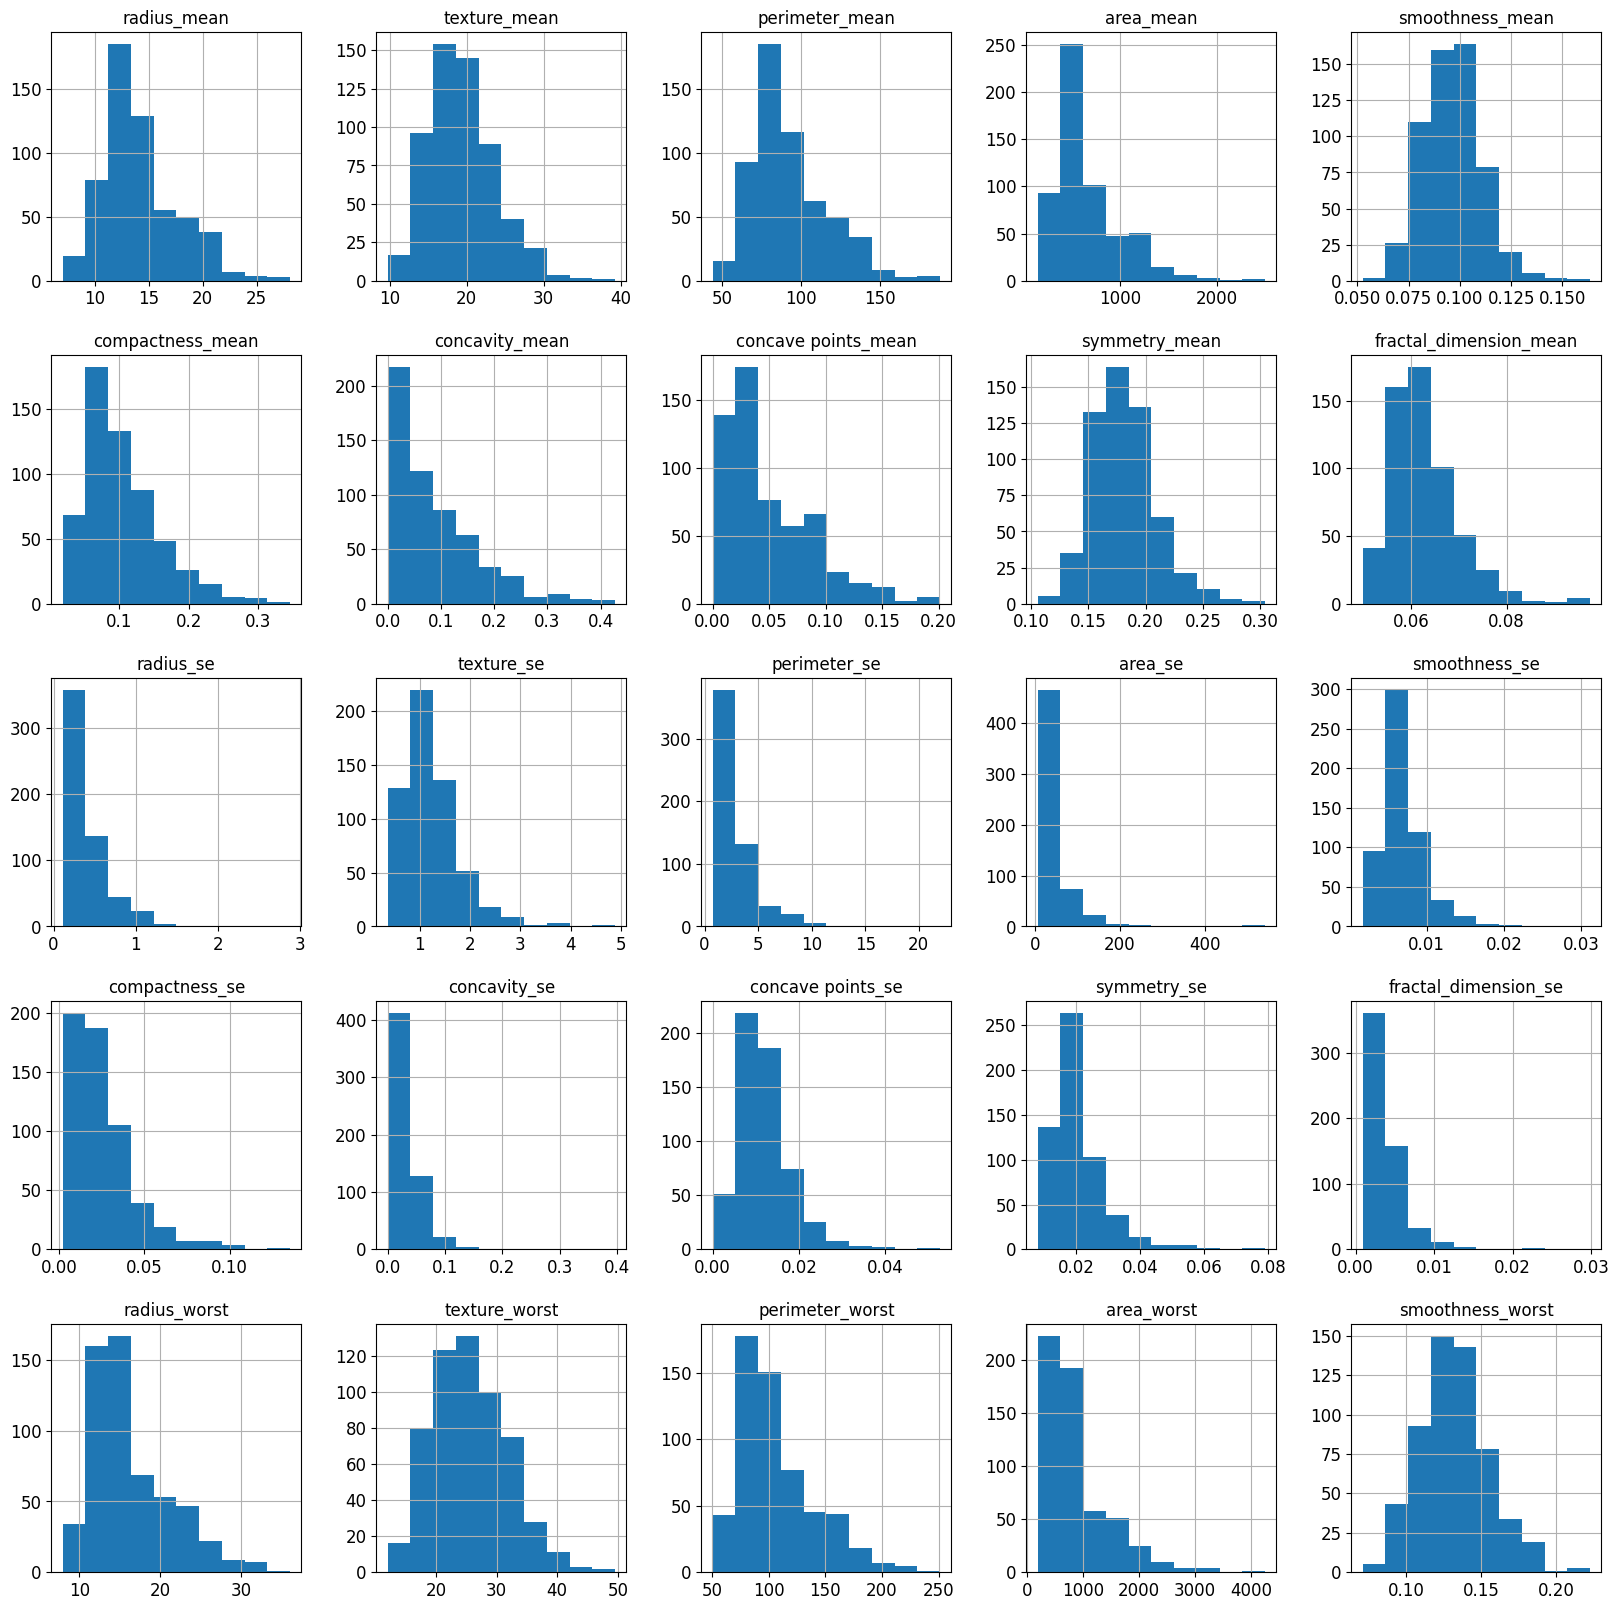

In [168]:
df_cancer.hist(figsize=(20,20));

In [169]:
columnas_log= ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst','smoothness_mean','smoothness_worst' ]



NOTA: Para más información sobre el dataset el hospital nos redirige a esta [página web](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download)

### Ejercicio 3: Split

Haz el split en train y test.

In [170]:
X= df_cancer.drop(["diagnosis"], axis=1)

y= df_cancer["diagnosis"]

In [171]:
X_train, X_test, y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [172]:
#logaritmizamos

df_cancer_log= np.log1p(df_cancer[df_cancer.columns[1:]])

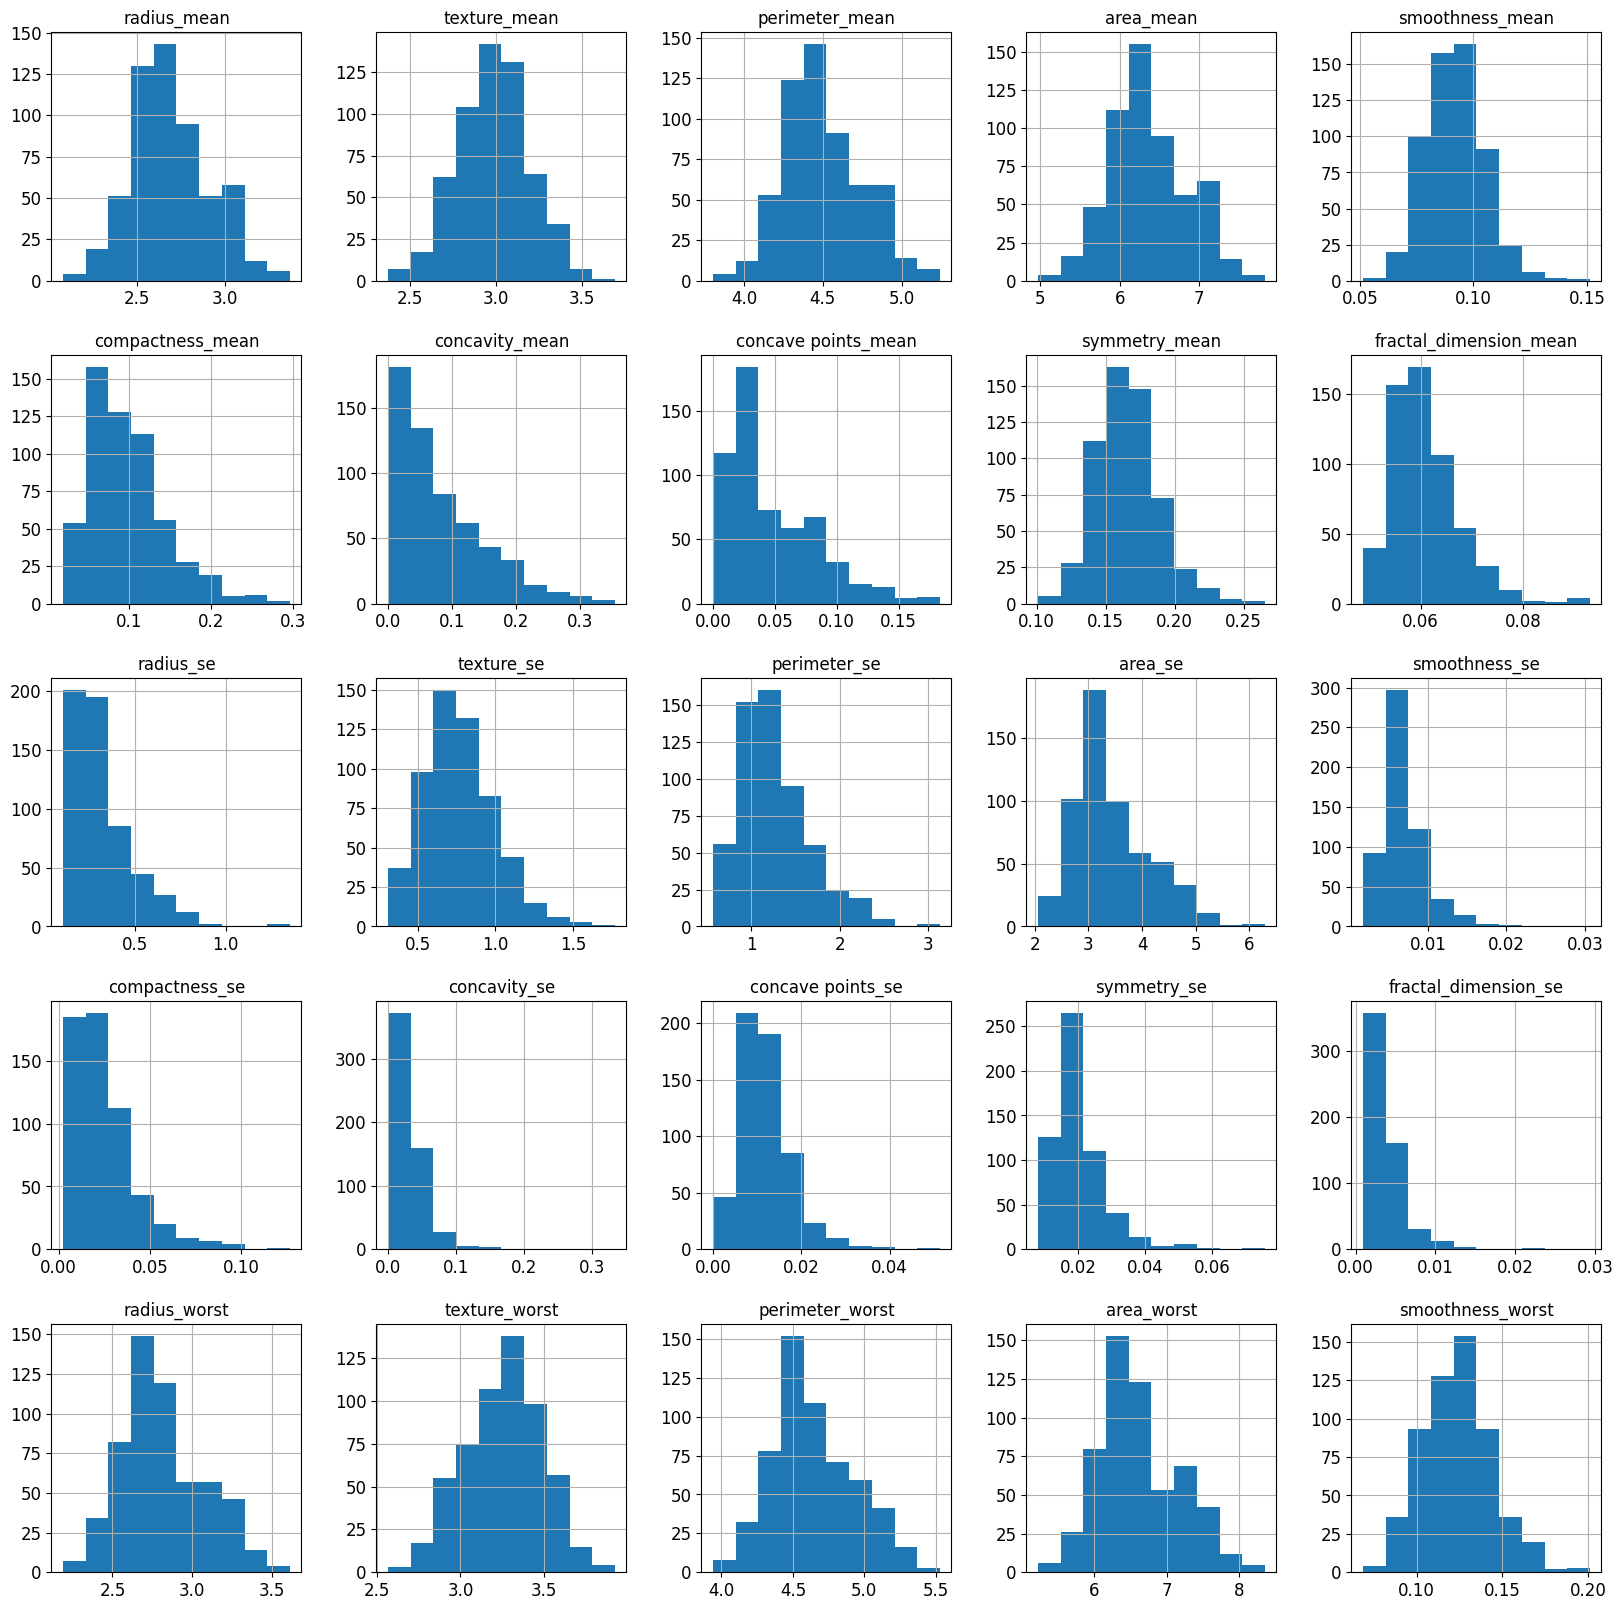

In [173]:
df_cancer_log.hist(figsize=(20,20));

### Ejercicio 4: MiniEDA (I)

Analiza la distribución frecuencial de target brevemente.

<Axes: xlabel='diagnosis', ylabel='Count'>

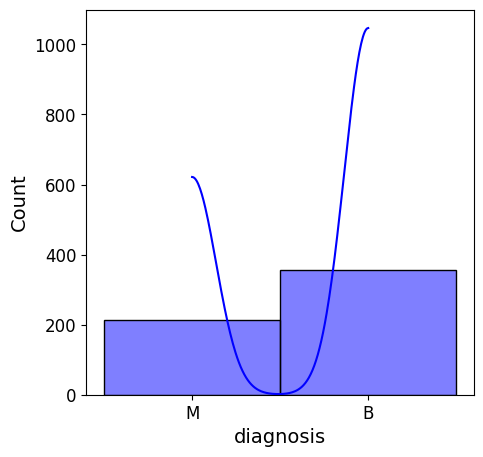

In [174]:
plt.figure(figsize=(5,5))
sns.histplot(df_cancer.diagnosis, kde=True, color='blue')

In [175]:
y.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [176]:
# frecuencia relativa
df_cancer.diagnosis.value_counts()/len(df_cancer)*100

diagnosis
B    62.741652
M    37.258348
Name: count, dtype: float64

Es una columna categoriga nominal con valor M o B, estando bastante bien equilibrada, pero es tipo object asi que es mejor pasar y convertir M y B, en 1 y 0

In [177]:
# Función para convertir la categoría a binario
def convertir_a_binario(categoria):
    if categoria == "M":
        return 0
    elif categoria == "B":
        return 1

# Aplicar la función a la columna
df_cancer["diagnosis"] = df_cancer["diagnosis"].map(convertir_a_binario)

# Visualizar el dataframe
df_cancer.head(10)

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          0        17.99         10.38          122.80     1001.0   
1          0        20.57         17.77          132.90     1326.0   
2          0        19.69         21.25          130.00     1203.0   
3          0        11.42         20.38           77.58      386.1   
4          0        20.29         14.34          135.10     1297.0   
5          0        12.45         15.70           82.57      477.1   
6          0        18.25         19.98          119.60     1040.0   
7          0        13.71         20.83           90.20      577.9   
8          0        13.00         21.82           87.50      519.8   
9          0        12.46         24.04           83.97      475.9   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760         0.30010              0.14710   
1          0.08474           0.07864         0.08690              0.07017   
2          0.10960           0.15990         0.19740              0.12790   
3          0.14250           0.28390         0.24140              0.10520   
4          0.10030           0.13280         0.19800              0.10430   
5          0.12780           0.17000         0.15780              0.08089   
6          0.09463           0.10900         0.11270              0.07400   
7          0.11890           0.16450         0.09366              0.05985   
8          0.12730           0.19320         0.18590              0.09353   
9          0.11860           0.23960         0.22730              0.08543   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   
5         0.2087                 0.07613     0.3345      0.8902         2.217   
6         0.1794                 0.05742     0.4467      0.7732         3.180   
7         0.2196                 0.07451     0.5835      1.3770         3.856   
8         0.2350                 0.07389     0.3063      1.0020         2.406   
9         0.2030                 0.08243     0.2976      1.5990         2.039   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   
5    27.19       0.007510         0.03345       0.03672            0.01137   
6    53.91       0.004314         0.01382       0.02254            0.01039   
7    50.96       0.008805         0.03029       0.02488            0.01448   
8    24.32       0.005731         0.03502       0.03553            0.01226   
9    23.94       0.007149         0.07217       0.07743            0.01432   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   
5      0.02165              0.005082         15.47          23.75   
6      0.01369              0.002179         22.88          27.66   
7      0.01486              0.005412         17.06          28.14   
8      0.021

In [178]:
df_cancer_log.head(1)

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0     2.943913      2.431857        4.818667   6.909753         0.111899   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0          0.244983        0.262441             0.137237       0.216642   

   fractal_dimension_mean  radius_se  texture_se  perimeter_se   area_se  \
0                0.075766   0.739554    0.644639      2.260617  5.039547   

   smoothness_se  compactness_se  concavity_se  concave points_se  \
0       0.006379        0.047875      0.052336           0.015745   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0     0.029588              0.006174      3.272606       2.908539   

   perimeter_worst  area_worst  smoothness_worst  
0         5.223594    7.610853          0.150315

In [179]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    int64  
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
 11  radius_se               569 non-null    float64
 12  texture_se              569 non-null    float64
 13  perimeter_se            569 non-null    float64
 14  area_se                 569 non-null    fl

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, de forma que veamos las distintas distribuciones para cada clase (puedes emplear la libería gráfica que crees conveniente)

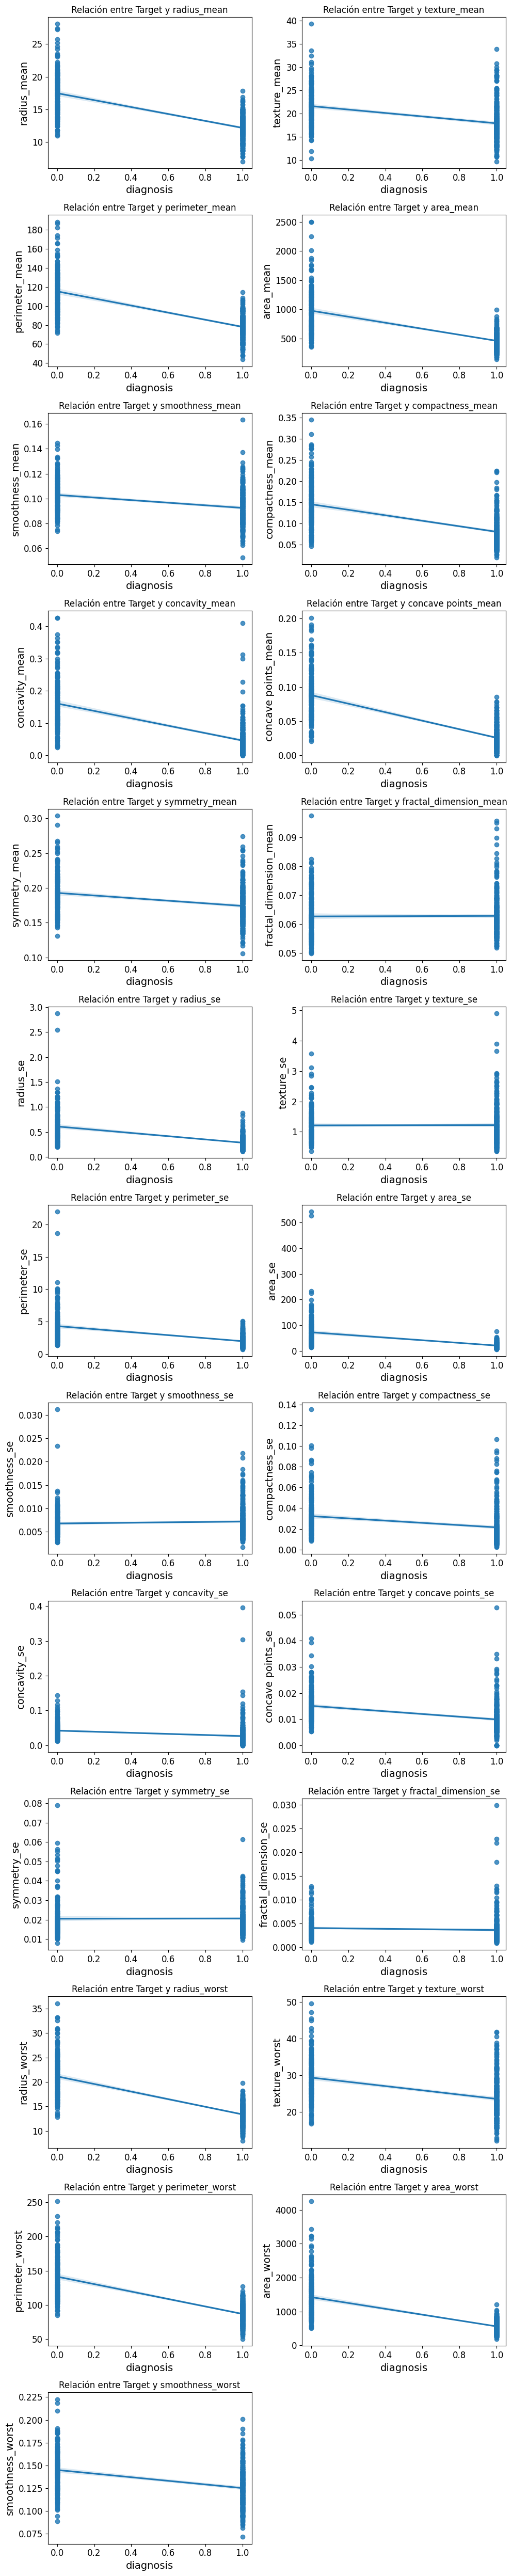

In [180]:
plt.figure(figsize=(10, 50))
num_plots = min(len(X), 26)

# Bucle para trazar cada relación
for i, column in enumerate(X[:num_plots],1):
    plt.subplot(13, 2, i)  # Configuración de subgráficos
    sns.regplot(data=df_cancer, x="diagnosis", y=column)
    plt.title(f'Relación entre Target y {column}')

plt.tight_layout()
plt.show()

In [181]:
X.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst'],
      dtype='object')

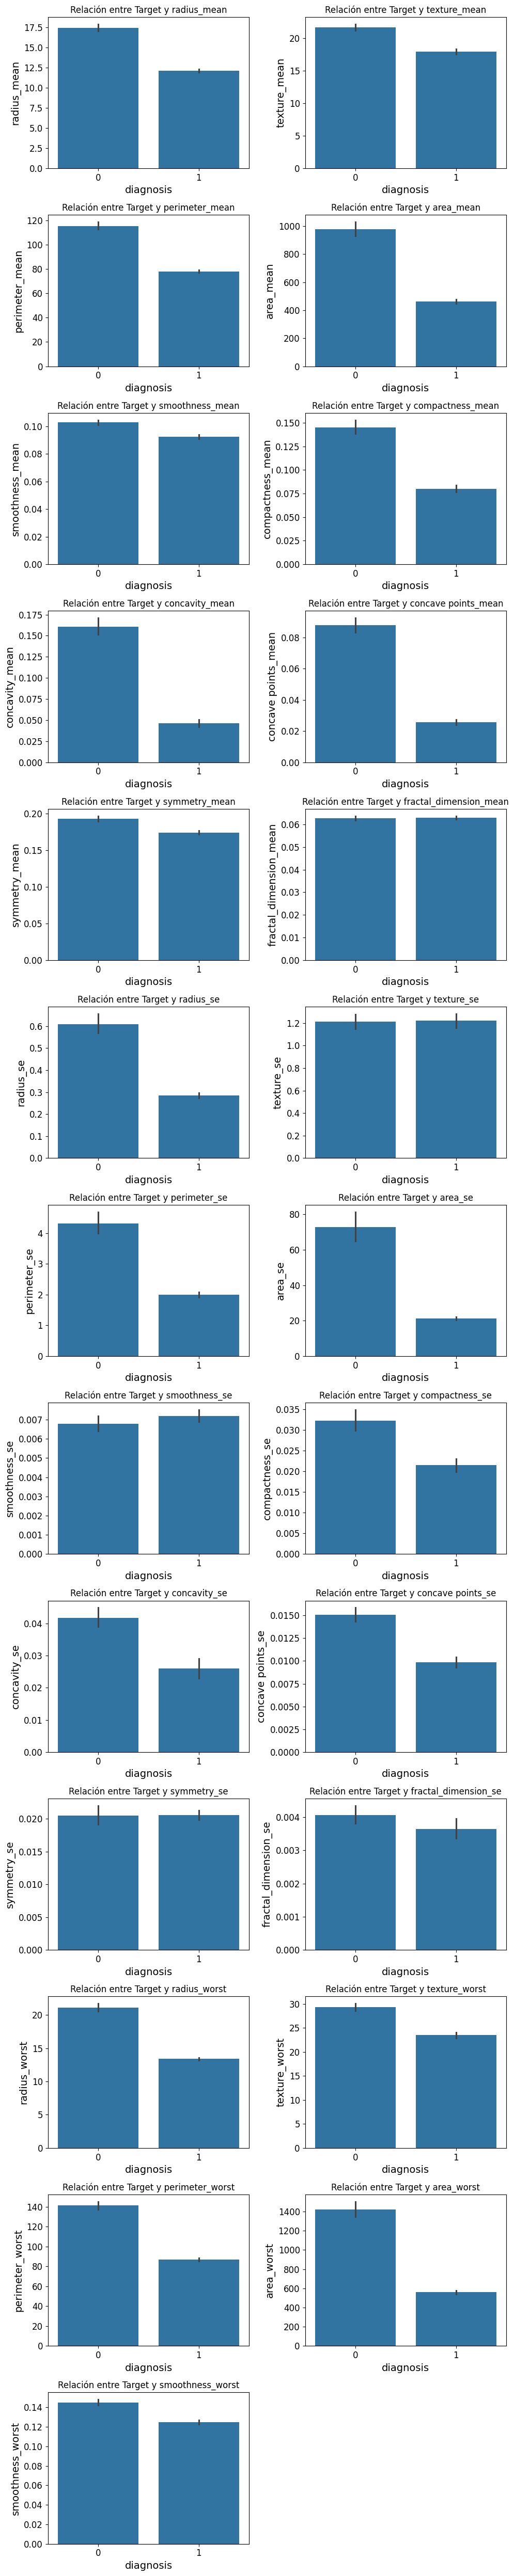

In [182]:
plt.figure(figsize=(10, 50))
num_plots = min(len(X), 26)

# Bucle para trazar cada relación
for i, column in enumerate(X[:num_plots],1):
    plt.subplot(13, 2, i)  # Configuración de subgráficos
    sns.barplot(data=df_cancer, x="diagnosis", y=column)
    plt.title(f'Relación entre Target y {column}')

plt.tight_layout()
plt.show()

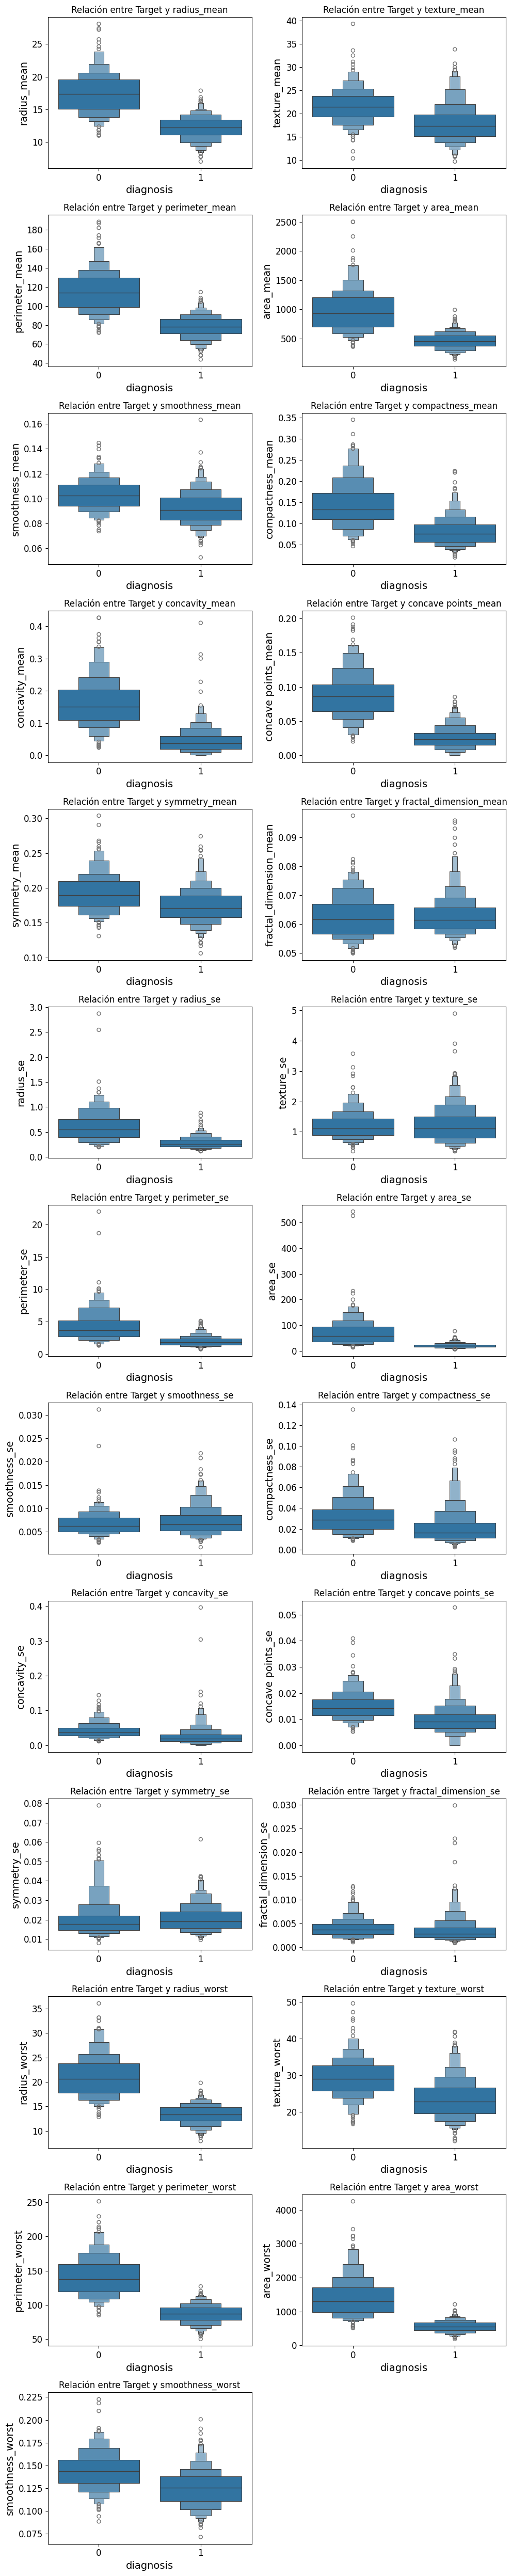

In [183]:
plt.figure(figsize=(10, 50))
num_plots = min(len(X), 26)

# Bucle para trazar cada relación
for i, column in enumerate(X[:num_plots],1):
    plt.subplot(13, 2, i)  # Configuración de subgráficos
    sns.boxenplot(data=df_cancer, x="diagnosis", y=column)
    plt.title(f'Relación entre Target y {column}')

plt.tight_layout()
plt.show()

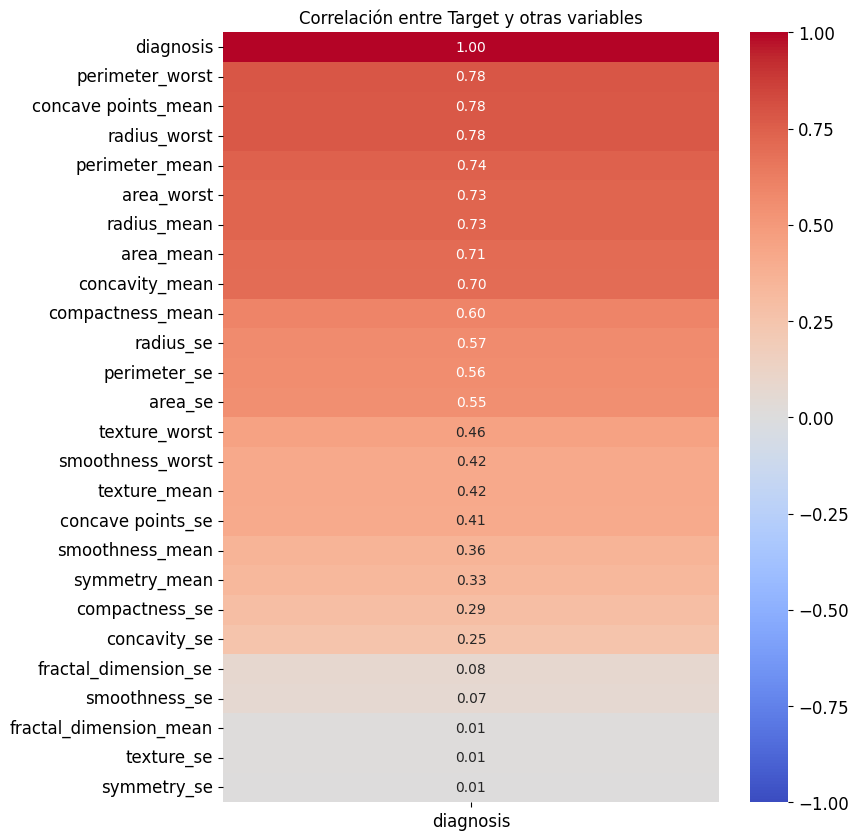

In [184]:
# correlacion entre variables 

correlation_matrix = np.abs(df_cancer.corr(numeric_only=True)).sort_values(ascending=False, by='diagnosis')

# Configuración del tamaño de la figura
plt.figure(figsize=(8, 10))

# Mapa de calor de la correlación
sns.heatmap(correlation_matrix[['diagnosis']], annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

plt.title('Correlación entre Target y otras variables')
plt.show()


In [185]:
df_cancer.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst'],
      dtype='object')

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

1. Target= diagnosis<br>
2. Features= las que tienen una correlacion superrior al 0.5 y ademas tienen pocos outlayers y una prorcion similar a la target son: ['perimeter_mean','smoothness_mean','compactness_mean','radius_se','texture_se','perimeter_se', 'area_se', 'smoothness_se','concavity_se','concave points_se', 'fractal_dimension_se','radius_worst', 'perimeter_worst']

3. modelos Xgboost, LightGBM, RandomForest y como modelo adicional Logistic Regression

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

In [186]:
Features=['perimeter_mean','smoothness_mean','compactness_mean','radius_se','texture_se',
                   'perimeter_se', 'area_se', 'smoothness_se','concavity_se','concave points_se', 
                   'fractal_dimension_se','radius_worst', 'perimeter_worst']
Target=['diagnosis']

In [187]:
print("Forma de Features:", Features)
print("Forma de Target:", Target)

Forma de Features: ['perimeter_mean', 'smoothness_mean', 'compactness_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'concavity_se', 'concave points_se', 'fractal_dimension_se', 'radius_worst', 'perimeter_worst']
Forma de Target: ['diagnosis']


In [188]:
df_cancer_elegido= df_cancer_log[Features]

In [189]:
df_cancer_target= pd.concat([df_cancer_elegido, df_cancer.diagnosis],axis=1)

In [190]:
df_cancer_target

perimeter_mean  smoothness_mean  compactness_mean  radius_se  texture_se  \
0          4.818667         0.111899          0.244983   0.739554    0.644639   
1          4.897093         0.081340          0.075701   0.434053    0.550373   
2          4.875197         0.104000          0.148334   0.557098    0.580482   
3          4.364117         0.133219          0.249902   0.402527    0.768255   
4          4.913390         0.095583          0.124692   0.563722    0.577343   
..              ...              ...               ...        ...         ...   
564        4.962845         0.105261          0.109661   0.777488    0.813593   
565        4.884316         0.093308          0.098396   0.568434    1.242135   
566        4.694096         0.081165          0.097399   0.375968    0.729961   
567        4.949469         0.111362          0.244514   0.545807    0.953587   
568        3.890186         0.051292          0.042695   0.326205    0.887068   

     perimeter_se   area_se  smoothness_se  concavity_se  concave points_se  \
0        2.260617  5.039547       0.006379      0.052336           0.015745   
1        1.481150  4.318554       0.005211      0.018429           0.013311   
2        1.720084  4.554193       0.006131      0.037604           0.020371   
3        1.491780  3.340385       0.009069      0.055066           0.018498   
4        1.862218  4.558498       0.011424      0.055321           0.018675   
..            ...       ...            ...           ...                ...   
564      2.160215  5.073297       0.010247      0.050674           0.024244   
565      1.825033  4.605570       0.005752      0.038740           0.016641   
566      1.487270  3.902982       0.005886      0.046215           0.015450   
567      1.912796  4.468434       0.006501      0.068752           0.016503   
568      1.266384  3.003204       0.007163      0.000000           0.000000   

     fractal_dimension_se  radius_worst  perimeter_worst  diagnosis  
0                0.006174      3.272606         5.223594          0  
1                0.003526      3.257712         5.073923          0  
2                0.004561      3.201526         5.033701          0  
3                0.009166      2.766948         4.603869          0  
4                0.005102      3.158701         5.031744          0  
..                    ...           ...              ...        ...  
564              0.004230      3.275256         5.118592          0  
565              0.002495      3.206398         5.049856          0  
566              0.003884      2.994732         4.849684          0  
567              0.006166      3.286161         5.223594          0  
568              0.002779      2.347176         4.097008          1  

[569 rows x 14 columns]

In [191]:
bt.obtener_estadisticas(df_cancer_target)

porcentaje_cardinalidad     Tipo media moda   std   var  \
perimeter_mean                         91.74  float64   4.5   No  0.25  0.06   
smoothness_mean                         83.3  float64  0.09   No  0.01   0.0   
compactness_mean                       94.38  float64   0.1   No  0.05   0.0   
radius_se                               94.9  float64  0.32   No  0.17  0.03   
texture_se                             91.21  float64  0.77   No  0.23  0.05   
perimeter_se                           93.67  float64  1.26   No   0.4  0.16   
area_se                                92.79  float64  3.42   No  0.71   0.5   
smoothness_se                          96.13  float64  0.01   No   0.0   0.0   
concavity_se                           93.67  float64  0.03   No  0.03   0.0   
concave points_se                       89.1  float64  0.01   No  0.01   0.0   
fractal_dimension_se                   95.78  float64   0.0   No   0.0   0.0   
radius_worst                           80.32  float64  2.81   No  0.26  0.07   
perimeter_worst                        90.33  float64  4.64   No  0.29  0.08   
diagnosis                               0.35    int64  0.63   No  0.48  0.23   

                        Q1 mediana    Q3          Categoria porcentaje_NaN  
perimeter_mean        4.33    4.47  4.65  numerica continua            0.0  
smoothness_mean       0.08    0.09   0.1  numerica continua            0.0  
compactness_mean      0.06    0.09  0.12  numerica continua            0.0  
radius_se             0.21    0.28  0.39  numerica continua            0.0  
texture_se            0.61    0.75  0.91  numerica continua            0.0  
perimeter_se          0.96    1.19  1.47  numerica continua            0.0  
area_se               2.94    3.24  3.83  numerica continua            0.0  
smoothness_se         0.01    0.01  0.01  numerica continua            0.0  
concavity_se          0.01    0.03  0.04  numerica continua            0.0  
concave points_se     0.01    0.01  0.01  numerica continua            0.0  
fractal_dimension_se   0.0     0.0   0.0  numerica continua            0.0  
radius_worst          2.64    2.77  2.99  numerica continua            0.0  
perimeter_worst       4.44    4.59  4.84  numerica continua            0.0  
diagnosis              0.0     1.0   1.0  numerica discreta            0.0

In [192]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    int64  
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
 11  radius_se               569 non-null    float64
 12  texture_se              569 non-null    float64
 13  perimeter_se            569 non-null    float64
 14  area_se                 569 non-null    fl

In [193]:
df_cancer_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   perimeter_mean        569 non-null    float64
 1   smoothness_mean       569 non-null    float64
 2   compactness_mean      569 non-null    float64
 3   radius_se             569 non-null    float64
 4   texture_se            569 non-null    float64
 5   perimeter_se          569 non-null    float64
 6   area_se               569 non-null    float64
 7   smoothness_se         569 non-null    float64
 8   concavity_se          569 non-null    float64
 9   concave points_se     569 non-null    float64
 10  fractal_dimension_se  569 non-null    float64
 11  radius_worst          569 non-null    float64
 12  perimeter_worst       569 non-null    float64
 13  diagnosis             569 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 62.4 KB


### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [194]:
X_train, X_test, y_train, y_test= train_test_split( df_cancer_target.iloc[:,0:12], df_cancer_target.iloc[:,13], test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(455, 12)
(114, 12)
(455,)
(114,)


### Ejercicio 9: Instanciación de modelos

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. Si quieres emplear la regresión logística es posible que tengas que utilizar un valor de max_iter para que el algoritmo converja.

modelos Xgboost, LightGBM, RandomForest y como modelo adicional Logistic Regression

### 1. xgbosster

In [195]:


xgb = xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.1, n_estimators=1000, max_depth=5)


xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))
print(xgb.score(X_test, y_test))





[[40  3]
 [ 1 70]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

0.9649122807017544


HIPERPARAMETROS

In [197]:

xgb_h =XGBClassifier()

# Definir la grilla de parámetros para la búsqueda en cuadrícula
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de estimadores (árboles) en el modelo
    'learning_rate': [0.05, 0.1, 0.2],  # Tasa de aprendizaje
    'max_depth': [5, 10, 15],  # Profundidad máxima de los árboles
    'min_child_weight': [1, 5, 10],  # Peso mínimo de la hoja hijo
    'gamma': [0, 0.1, 0.2]  # Parámetro de regularización gamma
}

# Realizar la búsqueda en cuadrícula con validación cruzada
xgb_random_search = RandomizedSearchCV(estimator=xgb_h, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Entrenar la búsqueda en cuadrícula en los datos de entrenamiento
xgb_random_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(xgb_random_search.best_params_)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores parámetros encontrados:
{'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0.1}


APLICO OPTIMIZACION

In [199]:

xgb_h = XGBClassifier(n_estimators= 300,learning_rate=0.05, max_depth=15, min_child_weight=1, gamma= 0.1)


xgb_h.fit(X_train, y_train)
xgb_h_pred = xgb_h.predict(X_test)

print(confusion_matrix(y_test, xgb_h_pred))
print(classification_report(y_test, xgb_h_pred))
print(xgb_h.score(X_test, y_test))


[[40  3]
 [ 1 70]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

0.9649122807017544


In [200]:
print(xgb_h.feature_importances_)

[0.05012902 0.0386689  0.10666586 0.02612178 0.06954025 0.03710306
 0.02674879 0.06570335 0.04162718 0.05244822 0.04006665 0.4451769 ]


In [201]:
xgb_h.feature_names_in_

array(['perimeter_mean', 'smoothness_mean', 'compactness_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se',
       'smoothness_se', 'concavity_se', 'concave points_se',
       'fractal_dimension_se', 'radius_worst'], dtype='<U20')

In [202]:
Features_import_xgb_h= pd.DataFrame( {'Features': xgb_h.feature_names_in_, 'Importance': xgb_h.feature_importances_}).sort_values(by= "Importance", ascending=True)

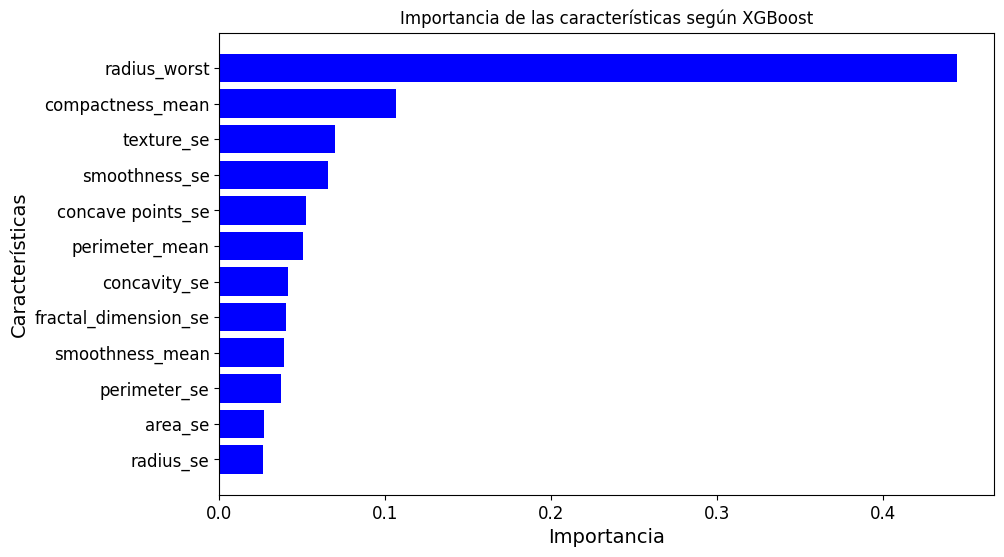

In [203]:

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(Features_import_xgb_h['Features'], Features_import_xgb_h['Importance'], color='blue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características según XGBoost')
plt.show()


columnas mas influyentes: ["radius_boost", "compactness_mean", "texture_se","smoothness_se", "concave points_se", "perimeter_mean"] 

### 2.- lightLGBM

In [204]:
lgb=lgb.LGBMClassifier(n_estimators=100,learning_rate=0.05,max_depth=5,num_leaves=10)

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [205]:
print(classification_report(y_test, lgb_pred))
print(confusion_matrix(y_test, lgb_pred))
lgb_acc = accuracy_score(y_test, lgb_pred)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

[[40  3]
 [ 1 70]]


APLICO OPTIMIZACION

In [206]:

lgb_h = LGBMClassifier()

# Definir la grilla de parámetros para la búsqueda en cuadrícula
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de estimadores (árboles) en el modelo
    'learning_rate': [0.05, 0.1, 0.2],  # Tasa de aprendizaje
    'max_depth': [5, 10, 15],  # Profundidad máxima de los árboles
    'num_leaves': [10, 20, 30]  # Número máximo de hojas en los árboles
}

# Realizar la búsqueda aleatoria con validación cruzada
lgb_random_search = RandomizedSearchCV(estimator=lgb_h, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Entrenar la búsqueda en cuadrícula en los datos de entrenamiento
lgb_random_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(lgb_random_search.best_params_)


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

APLICO CON OPTIMIZACION

In [207]:
lgb_h=LGBMClassifier(n_estimators=200,learning_rate=0.05,max_depth=10,num_leaves=20)

lgb_h.fit(X_train, y_train)
lgbh_pred = lgb_h.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [208]:
print(classification_report(y_test, lgb_pred))
print(confusion_matrix(y_test, lgb_pred))
lgbh_acc = accuracy_score(y_test, lgbh_pred)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

[[40  3]
 [ 1 70]]


In [209]:

lgb_h.feature_importances_



array([310, 335, 530, 133, 415, 119, 155, 214, 303, 155, 261, 763])

In [210]:
lgb_h.feature_name_


['perimeter_mean',
 'smoothness_mean',
 'compactness_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'concavity_se',
 'concave_points_se',
 'fractal_dimension_se',
 'radius_worst']

In [211]:
Features_import_lgb_h= pd.DataFrame( {'Features': lgb_h.feature_name_, 'Importance': lgb_h.feature_importances_}).sort_values(by= "Importance", ascending=True)

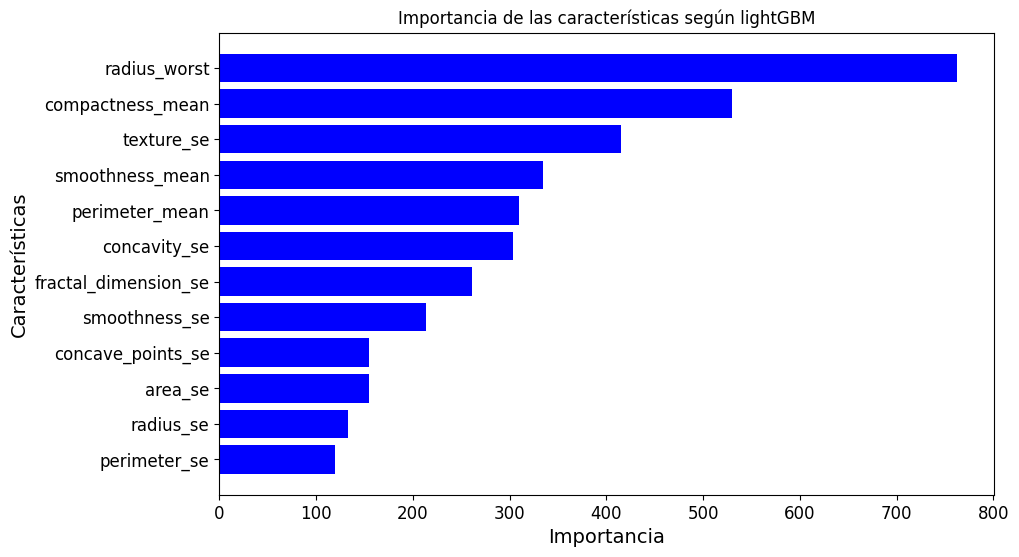

In [212]:

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(Features_import_lgb_h['Features'], Features_import_lgb_h['Importance'], color='blue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características según lightGBM')
plt.show()


columnas mas influyentes: ["radius_boost", "compactness_mean", "texture_se","smoothness_mean","smoothness_se", "fractal_dimension_se"]

### 3. RANDONFOREST

In [213]:
rf=RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=1, min_samples_split=2, bootstrap=True)

rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)


print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.97      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

0.9649122807017544


BUSCAR LA MEJOR OPTIMIZACION

In [216]:
rf_h = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],     # Número mínimo de muestras requeridas para estar en un nodo hoja
    'bootstrap': [True, False]         # Método de muestreo con reemplazo
}

# Realizar la búsqueda aleatoria con validación cruzada
rf_random_search = RandomizedSearchCV(estimator=rf_h, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Entrenar la búsqueda aleatoria en los datos de entrenamiento
rf_random_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(rf_random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores parámetros encontrados:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}


APLICO OPTIMIZACION

In [217]:
rf_h=RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=2, min_samples_split=2, bootstrap=False)

rf_h.fit(X_train,y_train)
rf_h_pred=rf_h.predict(X_test)


print(classification_report(y_test, rf_h_pred))
print(accuracy_score(y_test, rf_h_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        43
           1       0.95      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

0.956140350877193


In [218]:
rf_h.feature_importances_

array([0.21684252, 0.03715541, 0.09553552, 0.04129898, 0.01659304,
       0.10168669, 0.11986466, 0.02124734, 0.0332596 , 0.02176638,
       0.02160222, 0.27314767])

In [219]:
rf_h.feature_names_in_

array(['perimeter_mean', 'smoothness_mean', 'compactness_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se',
       'smoothness_se', 'concavity_se', 'concave points_se',
       'fractal_dimension_se', 'radius_worst'], dtype=object)

In [220]:
Features_import_rf_h= pd.DataFrame( {'Features': rf_h.feature_names_in_, 'Importance': rf_h.feature_importances_}).sort_values(by= "Importance", ascending=True)

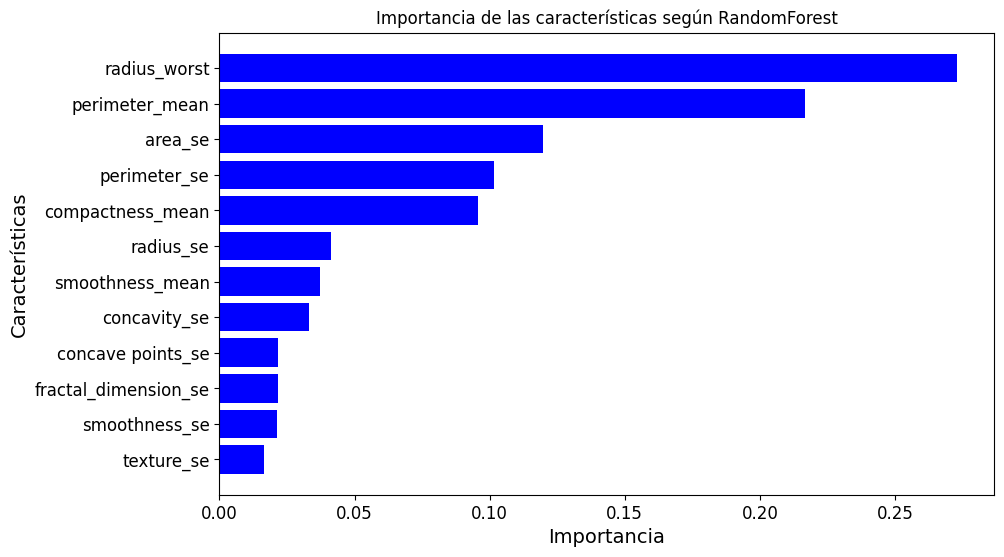

In [221]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(Features_import_rf_h['Features'], Features_import_rf_h['Importance'], color='blue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características según RandomForest')
plt.show()

columnas mas influyentes: ["radius_boost", "perimeter_mean" "area_se", , "compactness_mean", "perimeter_se","radius_se"]

### METODOS DE COMBINACION DE PREDICCIONES

In [222]:
# Combinación de predicciones

xgb_predictions = xgb_h.predict(X_test)
lgb_predictions = lgb_h.predict(X_test)
rf_predictions = rf_h.predict(X_test)


In [223]:
combined_predictions = (xgb_predictions + lgb_predictions + rf_predictions) / 3

#### MODLEO STALKING COMBINANDO LOS 3 ANTERIORES, APLICANDO LE EL VOTING

In [224]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

# Stacking (entrena un metamodelo sobre predicciones individuales)
modelos = [('xgb', xgb_h), ('lgb', lgb_h), ('rf', rf_h)]
estimador_final = RandomForestClassifier()
clf_stalking = StackingClassifier(estimators=modelos, final_estimator=estimador_final)
clf_stalking.fit(X_train, y_train)
predicciones_combinadas = clf_stalking.predict(X_test)

# Voting (combina las predicciones directamente)
voting = VotingClassifier(estimators=modelos)
voting.fit(X_train, y_train)
predicciones_combinadas = voting.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [225]:
print(classification_report(y_test, predicciones_combinadas))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



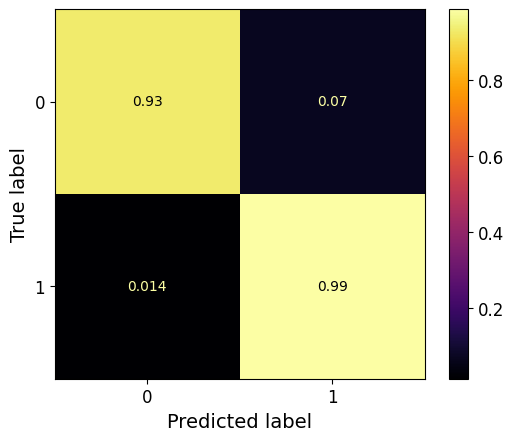

In [226]:
ConfusionMatrixDisplay.from_predictions(y_test, predicciones_combinadas, normalize='true', cmap=plt.cm.inferno)

C:\Users\victo\AppData\Local\Temp\ipykernel_11076\559697096.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}%'.format(y) for y in np.arange(0, 101, 20)])


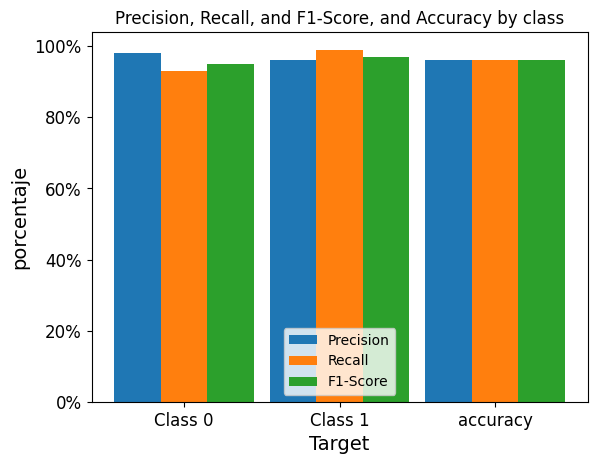

In [ ]:
# Definir las métricas y las clases
precision = [0.98, 0.96]
recall = [0.93, 0.99]
f1_score = [0.95, 0.97]
accuracy=0.96
classes = ["Class 0", "Class 1", "accuracy"]

# Convertir valores a porcentaje
precision_percent = np.array(precision) * 100
recall_percent = np.array(recall) * 100
f1_score_percent = np.array(f1_score) * 100
accuracy_percent = accuracy * 100

# Crear un gráfico de barras
bar_width = 0.3
index = range(len(classes))
fig, ax = plt.subplots()
bar1 = ax.bar(index, precision + [accuracy], bar_width, label='Precision')
bar2 = ax.bar([i + bar_width for i in index], recall + [accuracy], bar_width, label='Recall')
bar3 = ax.bar([i + 2 * bar_width for i in index], f1_score + [accuracy], bar_width, label='F1-Score')

# Añadir etiquetas y leyenda
ax.set_xlabel('Target')
ax.set_ylabel('porcentaje')
ax.set_title("Precision, Recall, and F1-Score, and Accuracy by class")
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(classes)
ax.legend(loc="lower center")
ax.set_yticklabels(['{:,.0f}%'.format(y) for y in np.arange(0, 101, 20)])
plt.show()

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea el recall_medio y usa scoring = "balanced acuracy". Escoge el modelo ganador.

In [ ]:
modelos = [('xgb', XGBClassifier()), ('lgb', LGBMClassifier()), ('rf', RandomForestClassifier())]

resultados = []
for nombre, modelo in modelos:
    puntuaciones = cross_val_score(modelo, X_train, y_train, cv=5, scoring="balanced_accuracy")
    resultados.append({'Modelo': nombre, 'Precisión': np.mean(puntuaciones)})
    #print(f"Precisión media del modelo {nombre}: {np.mean(puntuaciones):.2%}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 228, number of negative: 136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626374 -> initscore=0.516691
[LightGBM] [Info] Start training from score 0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
df_resultados = pd.DataFrame(resultados)
df_resultados

Modelo  Precisión
0    xgb   0.913647
1    lgb   0.920604
2     rf   0.914862

GANADOR LBM

### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "balance accuracy". Por otro lado, incluye en el grid, el hiperparámetro que permita que el modelo "compense" el desbalanceo del dataset de entrada, aunque este no lo tenga.

In [ ]:

lgb_h = LGBMClassifier()

# Definir la grilla de parámetros para la búsqueda en cuadrícula
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de estimadores (árboles) en el modelo
    'learning_rate': [0.05, 0.1, 0.2],  # Tasa de aprendizaje
    'max_depth': [5, 10, 15],  # Profundidad máxima de los árboles
    'num_leaves': [10, 20, 30]  # Número máximo de hojas en los árboles
}

# Realizar la búsqueda aleatoria con validación cruzada
lgb_grid_search = GridSearchCV(estimator=lgb_h, param_grid=param_grid,cv=5, verbose=2, n_jobs=-1, scoring="balanced_accuracy")

# Entrenar la búsqueda en cuadrícula en los datos de entrenamiento
lgb_grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(lgb_grid_search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
lgb_optimizado=LGBMClassifier(n_estimators=100,learning_rate=0.05,max_depth=15,num_leaves=20)

lgb_optimizado.fit(X_train, y_train)
y_pred_optimizado = lgb_optimizado.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
print(F"Infoeme del modelo ganador (lightGBM) entre los 3 analizados(XGB, LGB y RF): \n {classification_report(y_test, y_pred_optimizado)}")

Infoeme del modelo ganador (lightGBM) entre los 3 analizados(XGB, LGB y RF): 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        43
           1       0.95      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



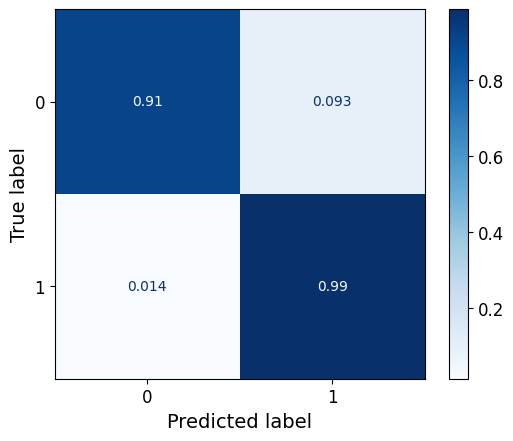

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimizado, normalize='true', cmap=plt.cm.Blues)

C:\Users\victo\AppData\Local\Temp\ipykernel_11076\313822765.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}%'.format(y) for y in np.arange(0, 101, 20)])


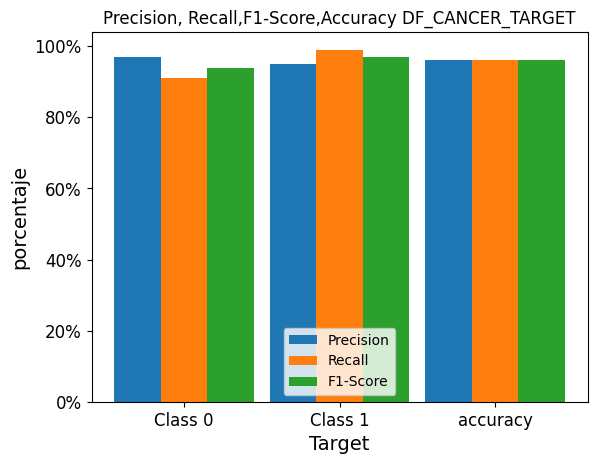

In [ ]:
# Definir las métricas y las clases
precision = [0.97, 0.95]
recall = [0.91, 0.99]
f1_score = [0.94, 0.97]
accuracy=0.96
classes = ["Class 0", "Class 1", "accuracy"]

# Convertir valores a porcentaje
precision_percent = np.array(precision) * 100
recall_percent = np.array(recall) * 100
f1_score_percent = np.array(f1_score) * 100
accuracy_percent = accuracy * 100

# Crear un gráfico de barras
bar_width = 0.3
index = range(len(classes))
fig, ax = plt.subplots()
bar1 = ax.bar(index, precision + [accuracy], bar_width, label='Precision')
bar2 = ax.bar([i + bar_width for i in index], recall + [accuracy], bar_width, label='Recall')
bar3 = ax.bar([i + 2 * bar_width for i in index], f1_score + [accuracy], bar_width, label='F1-Score')

# Añadir etiquetas y leyenda
ax.set_xlabel('Target')
ax.set_ylabel('porcentaje')
ax.set_title("Precision, Recall,F1-Score,Accuracy DF_CANCER_TARGET")
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(classes)
ax.legend(loc="lower center")
ax.set_yticklabels(['{:,.0f}%'.format(y) for y in np.arange(0, 101, 20)])
plt.show()

In [ ]:
Features_import_lgb_optimizado= pd.DataFrame( {'Features': lgb_optimizado.feature_name_, 'Importance': lgb_optimizado.feature_importances_}).sort_values(by= "Importance", ascending=True)

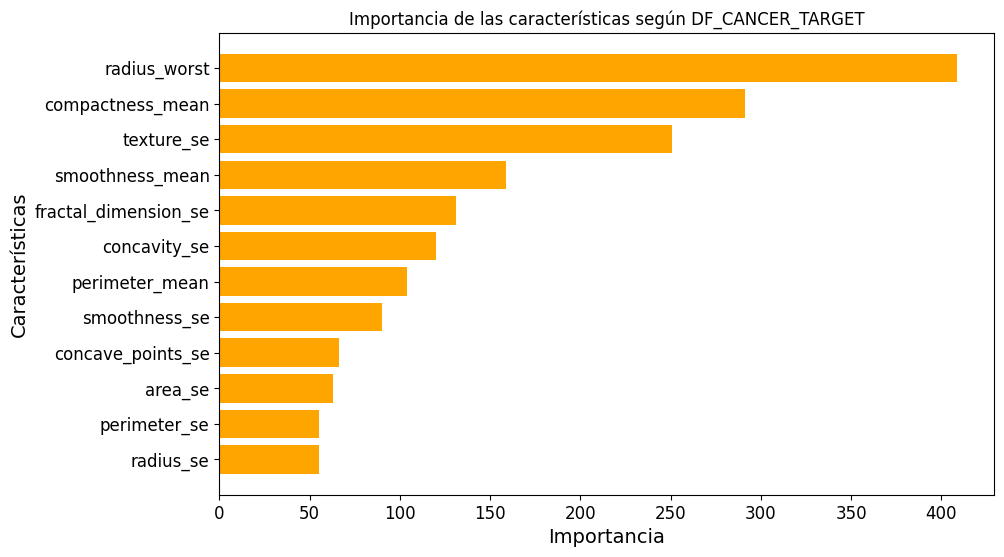

In [229]:

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(Features_import_lgb_optimizado['Features'], Features_import_lgb_optimizado['Importance'], color='orange')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características según DF_CANCER_TARGET')
plt.show()


### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [ ]:
df_cancer_tital_log= np.log1p(df_cancer[df_cancer.columns[:]])

In [ ]:
def convertir_valor(valor):
    if valor >0.5:
        return 1
    elif valor < 0.5:
        return 0
    else:
        return valor 

# Aplicar la función a la columna 'columna'
df_cancer_tital_log['diagnosis'] = df_cancer_tital_log['diagnosis'].apply(convertir_valor)

In [ ]:
df_cancer_tital_log.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          0     2.943913      2.431857        4.818667   6.909753   
1          0     3.071303      2.932260        4.897093   7.190676   
2          0     3.029650      3.102342        4.875197   7.093405   
3          0     2.519308      3.062456        4.364117   5.958683   
4          0     3.058237      2.730464        4.913390   7.168580   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0         0.111899          0.244983        0.262441             0.137237   
1         0.081340          0.075701        0.083330             0.067818   
2         0.104000          0.148334        0.180153             0.120357   
3         0.133219          0.249902        0.216240             0.100026   
4         0.095583          0.124692        0.180653             0.099212   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0       0.216642                0.075766   0.739554    0.644639      2.260617   
1       0.166531                0.055122   0.434053    0.550373      1.481150   
2       0.188055                0.058259   0.557098    0.580482      1.720084   
3       0.230874                0.092980   0.402527    0.768255      1.491780   
4       0.166277                0.057165   0.563722    0.577343      1.862218   

    area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0  5.039547       0.006379        0.047875      0.052336           0.015745   
1  4.318554       0.005211        0.012995      0.018429           0.013311   
2  4.554193       0.006131        0.039278      0.037604           0.020371   
3  3.340385       0.009069        0.071930      0.055066           0.018498   
4  4.558498       0.011424        0.024312      0.055321           0.018675   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0     0.029588              0.006174      3.272606       2.908539   
1     0.013794              0.003526      3.257712       3.194993   
2     0.022251              0.004561      3.201526       3.278276   
3     0.057920              0.009166      2.766948       3.314186   
4     0.017408              0.005102      3.158701       2.871868   

   perimeter_worst  area_worst  smoothness_worst  
0         5.223594    7.610853          0.150315  
1         5.073923    7.579168          0.116716  
2         5.033701    7.444249          0.134880  
3         4.603869    6.343353          0.190455  
4         5.031744    7.362645          0.128745

In [ ]:
# entreno con todo el dataset a veo los resultados
X_total= df_cancer_tital_log.drop(["diagnosis"], axis=1)
y_total= df_cancer_tital_log["diagnosis"]

In [ ]:
#split
X_train, X_test, y_train, y_test= train_test_split(X_total, y_total, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(455, 25)
(114, 25)
(455,)
(114,)


In [ ]:
#entreno modelo ganador
lgb_total=LGBMClassifier(n_estimators=100,learning_rate=0.05,max_depth=15,num_leaves=20)

lgb_total.fit(X_train, y_train)
y_pred_total= lgb_total.predict(X_test)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3792
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
Features_import_lgb_total= pd.DataFrame( {'Features': lgb_total.feature_name_, 'Importance': lgb_total.feature_importances_}).sort_values(by= "Importance", ascending=True)

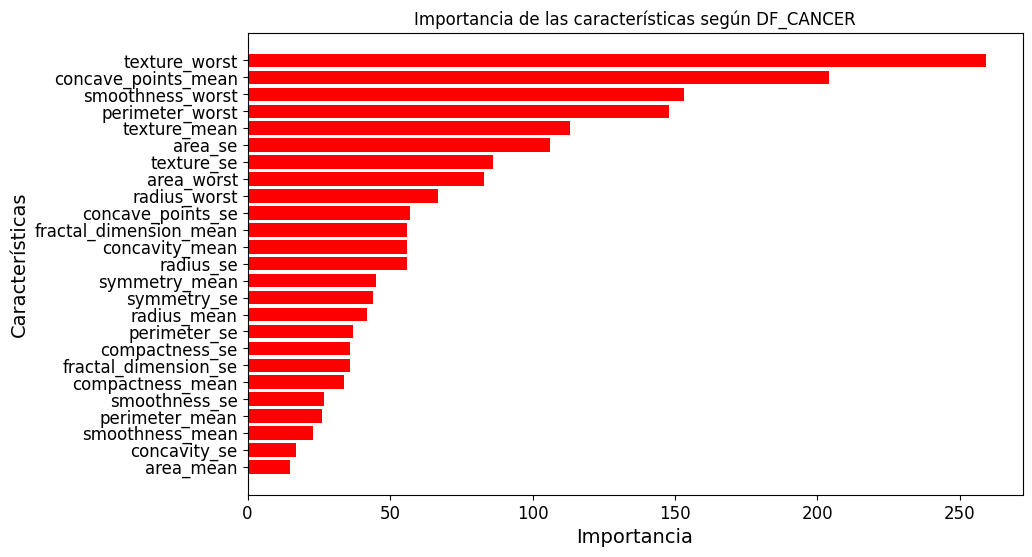

In [228]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(Features_import_lgb_total['Features'], Features_import_lgb_total['Importance'], color='red')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características según DF_CANCER')
plt.show()

In [ ]:
# evaluacion
print(f'informe con el total del dataset:\n{classification_report(y_test, y_pred_total)}')

informe con el total del dataset:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



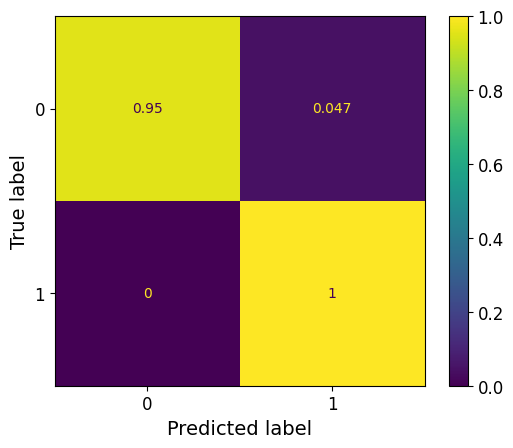

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_total, normalize="true")

C:\Users\victo\AppData\Local\Temp\ipykernel_11076\3183235452.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}%'.format(y) for y in np.arange(0, 101, 20)])


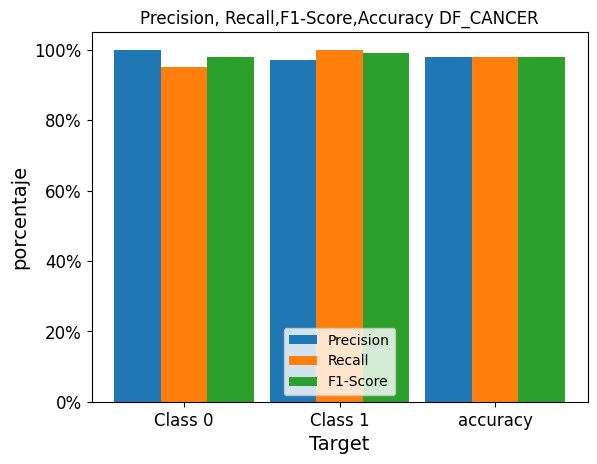

In [ ]:
# Definir las métricas y las clases
precision = [1, 0.97]
recall = [0.95, 1]
f1_score = [0.98, 0.99]
accuracy=0.98
classes = ["Class 0", "Class 1", "accuracy"]

# Convertir valores a porcentaje
precision_percent = np.array(precision) * 100
recall_percent = np.array(recall) * 100
f1_score_percent = np.array(f1_score) * 100
accuracy_percent = accuracy * 100

# Crear un gráfico de barras
bar_width = 0.3
index = range(len(classes))
fig, ax = plt.subplots()
bar1 = ax.bar(index, precision + [accuracy], bar_width, label='Precision')
bar2 = ax.bar([i + bar_width for i in index], recall + [accuracy], bar_width, label='Recall')
bar3 = ax.bar([i + 2 * bar_width for i in index], f1_score + [accuracy], bar_width, label='F1-Score')

# Añadir etiquetas y leyenda
ax.set_xlabel('Target')
ax.set_ylabel('porcentaje')
ax.set_title("Precision, Recall,F1-Score,Accuracy DF_CANCER")
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(classes)
ax.legend(loc="lower center")
ax.set_yticklabels(['{:,.0f}%'.format(y) for y in np.arange(0, 101, 20)])
plt.show()

### Ejercicio 13: Análisis de errores

Muestra la matriz de confusión con los porcentajes de precisión (emplea ConfusionMatrixDisplay.from_predictions con el argumento normalize con el valor adecuado). Haz un pequeño análisis.

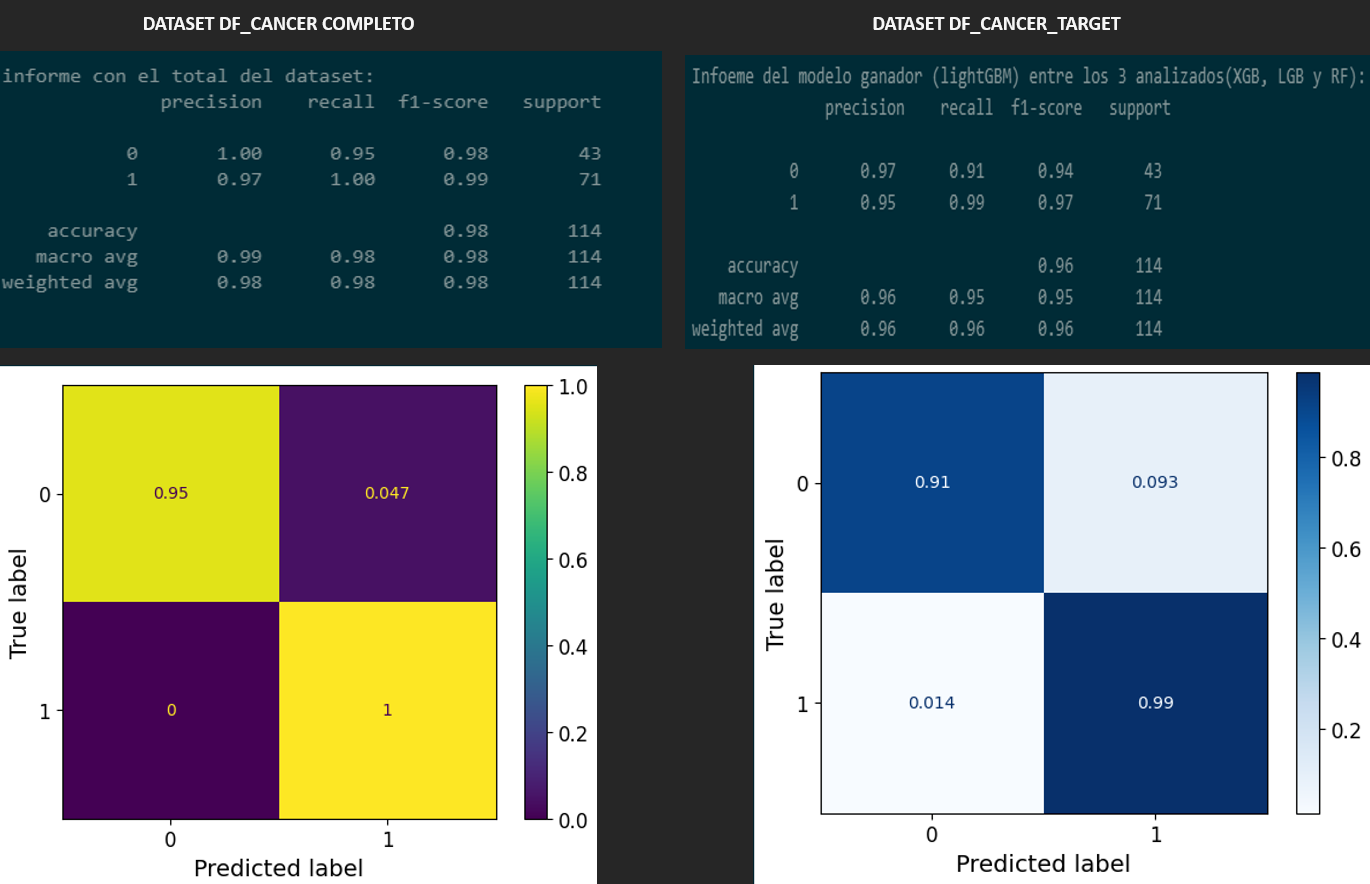

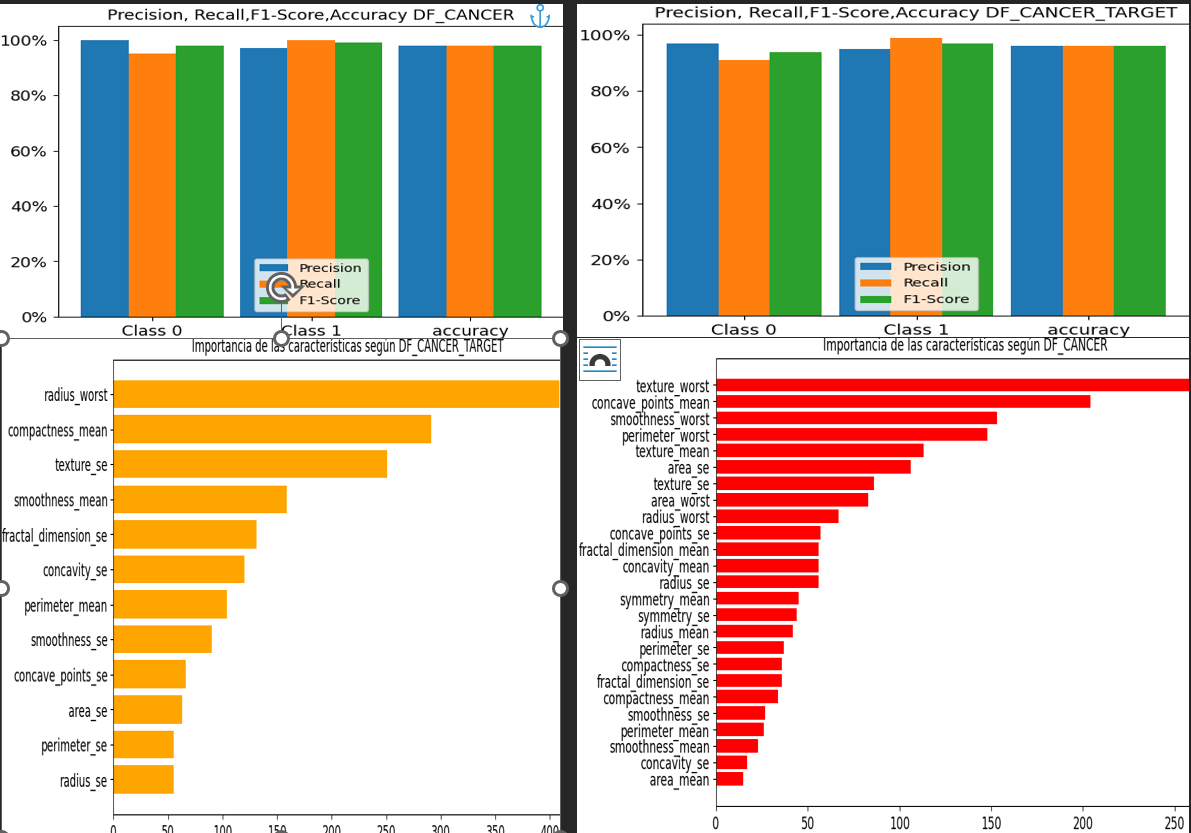

## CONCLUSION

Del analisis del dataset inicial, y debido al estudio de sus caractresticas, solo elegi para entrenar con los modelos predictorios algunas columnas, que por correlaciones y otras caracteristcas observadas en el minieda eran mas importantes, haciendo un dataframe con la target y la cas columans elegidas logaritmizadas(DF_CAMCER_TARGET). Este Dataset ha sido entrenando con los modelos XGboost, lightGBM y RandomForest, encontrandose la precision entre ellos entre un 91.3 al 92, siendo el de mayor precisión el LBM, realizando un grid de optimizacion , volviendo a entrenar este modelo.<br>
Posteriormente, he reazliado todos los pasos igual con el dataframe completo y logaritmizado, siendo las diferencias muy leves.<br>
Como se puede observar en las imagenes es un modelo perfecto, pero eso puede ser indice de sobreajuste a los valores de entrenamiento, tanto en la precision en aciertos estan por encima del 95% en ambas clases, tanto en precicison y sensibilidad y teniendo solo un 1% de errores positivos y un 0% en negativos.
Estos valores no son muy normales, pero se ha trabjado con disintos modelos asi que tenemos el modelo perfecto de prediccion para el cancer

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/cancer_pred" con la extesión apropiada.

In [234]:
from joblib import dump
import pickle

# modelo DF_CANCER
dump(lgb_total, "lgb_total.pkl")

data={"columna_lgb_total":[lgb_total]}
df_total=pd.DataFrame(data)

#guardamos
df_total.to_csv(r"D:\Cursos\REPOSITORIOS\ONLINE_DS_THEBRIDGE_V\models\cancer_pred\lgb_total.csv", index=False)




In [242]:
with open(r"D:\Cursos\REPOSITORIOS\ONLINE_DS_THEBRIDGE_V\models\cancer_pred\lgb_total.pkl", "wb") as w:
    pickle.dump(lgb_total,w)
    # se carga con pickle.load